# ResNet 구현

## 학습목표
> ResNet을 직접 구현해보고 CIFAR10 데이터셋 분류 모델을 학습시켜 본다. 또한 pre-trained ResNet을 CIFAR10 데이터셋으로 fine-tuning 하는 방법을 학습한다.


**목차(context)**
> 1. ResNet 설명
> 2. ResNet 모델 구현
> 3. CIFAR 10 데이터 불러오기
> 4. ResNet 모델 학습하기
> 5. Pre-trained ResNet fine-tuning 하기


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## ResNet 설명
> ResNet은 레이어를 쌓을 때 residual block을 사용한다. \
> 이러한 Residual connection의 주요 이점 중 하나는 gradient가 쉽게 흐를 수 있다는 것이다.\
> 이는 입력 𝑥가 변형 없이 그대로 전달되고,이는 네트워크가 입력 정보를 "보존"하면서 추가적인 특징을 학습할 수 있음을 의미.

<img src = "https://images.velog.io/images/junyoung9696/post/3137e50c-b52f-4cdd-8ae8-2faf497efe84/r10.png" width = 400>


> Residual block의 연산은 $𝐹(𝑥) + 𝑥$ 로써, 인풋 $x$의 값을 아웃풋 $F(x)$에 더해주는 방식으로 계산이 된다.
> 이 연산에서 인풋의 값을 그대로 더해주는 연산은 인풋 $x$에 1을 곱한 후 더해주는 함수로 생각할 수 있고, 따라서 이것의 미분 함수 또한 1을 곱해주는 것과 같다. => $(𝐹(𝑥) + 1 · 𝑥)′ = 𝐹′(𝑥) + 1$\
> 미분 시 항상 1이 더해지므로, 이러한 결과를 통해서 많은 레이어를 쌓았을 때, 학습 시 발생하는 문제인 vanishing gradient 문제를 해결할 수 있는 효과를 얻게 된다. \


>결과적으로 ResNet은 더 많은 레이어를 쌓아도 안정적으로 학습을 할 수 있게 되어 VGGNet보다 더 좋은 이미지 분류 결과를 달성한다.

> 7x7 Conv, 64 채널, stride 2\
> 3x3 Max Pool, stride 2\
> Conv2_x: 3x3 Conv, 64 채널, 3번 반복\
> Conv3_x: 3x3 Conv, 128 채널, 4번 반복\
> Conv4_x: 3x3 Conv, 256 채널, 6번 반복\
> Conv5_x: 3x3 Conv, 512 채널, 3번 반복\
> Average Pool, Fully Connected Layer


<br/>

<img src = "https://editor.analyticsvidhya.com/uploads/38371XTo6Q.png" width = 600, height=800>



## ResNet 모델 구현
> ResNet 구현은 두단계로 이루어져 있다. 첫번째는 residual block을 구현한다. 다음으로 이때 구현한 residual block과 함께 레이어를 쌓아서 ResNet을 구현한다.

> Residual block은 인풋으로 들어오는 텐서에 (컨볼루션 레이어, 배치 정규화, ReLU 활성 함수)로 구성된 연산 과정을 두번 시행하여 아웃풋을 만든다. 그리고 아웃풋에 현재 block의 인풋 값을 그대로 더해준다.

In [ ]:
# Residual Block 구현
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        #### conv block: cnn -> batchnorm2d -> relu -> conv2d -> batchnorm2d ####
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels)
            nn.ReLU()
        )
        ########################################################################

        self.shortcut = nn.Identity() # 각 블록에서 반복되는 부분들

        if stride != 1 or in_channels != out_channels: # Conv2_x -> Conv3_x, Conv3_x -> Conv4_x, Conv4_x -> Conv5_x

            ####### shortcut(skip-connection): conv2d -> batchnorm2d
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
            #########################################

    def forward(self, x):
        out = self.conv_block(x)
        out = out + self.shortcut(x)  # residual connection 부분
        out = F.relu(out)
        return out

> ResidualBlock 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
res_block = ResidualBlock(3, 3)
dummy_x = torch.randn([16, 3, 32, 32])
dummy_pred = res_block(dummy_x)
print(dummy_pred.shape)

torch.Size([16, 3, 32, 32])


> 위에서 선언한 residual block 함수를 이용하여 ResNet을 만든다. 이때 마지막 residual block의 아웃풋에 MLP 레이어를 한번 거쳐서 최종 예측값을 만든다.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Layer 1
        self.layer1 = nn.Sequential(
            block(64, 64, stride=1),
            *[block(64, 64) for _ in range(num_blocks[0] - 1)]
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            block(64, 128, stride=2),
            *[block(128, 128) for _ in range(num_blocks[1] - 1)]
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            block(128, 256, stride=2),
            *[block(256, 256) for _ in range(num_blocks[2] - 1)]
        )

        # Layer 4
        self.layer4 = nn.Sequential(
            block(256, 512, stride=2),
            *[block(512, 512) for _ in range(num_blocks[3] - 1)]
        )

        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

> ResNet 함수를 선언하고 생성된 모델의 구조를 확인한다.

In [ ]:
resnet = ResNet(ResidualBlock, [3, 4, 6, 3])
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

> ResNet 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
dummy_y = resnet(dummy_x)
print(dummy_y.shape)

torch.Size([16, 10])


## CIFAR 10 데이터 불러오기

> 이번 분류 모델 실습에서는 CIFAR10 데이터셋을 이용한다.
> CIFAR10 데이터셋은 50,000개의 학습 데이터와 10,000의 테스트 데이터로 구성되어 있다.  
> 각 데이터는 10개의 클래스 중 하나에 해당한다. 그리고 각 데이터의 크기는 가로 32, 세로 32의 채널 세개로 이루어져 있다.



> CIFAR10 데이터셋은 torchvision 라이브러리에 내장되어 있다.

In [ ]:
import torchvision.datasets as datasets

def CIFAR10_DATA(root='./data/', download = True, batch_size=32, num_worker=1):
    print ("[+] Get the CIFAR10 DATA")
    # 50,000장의 학습 데이터셋
    train_dataset = datasets.CIFAR10(root='./data/', train=True, transform=transforms.ToTensor(), download=True)  # 데이터셋 자동 다운로드
    # 10,000장의 테스트 데이터셋
    test_dataset = datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor())


    # 데이터셋을 미니배치화 시켜주기 위한 DataLoader 선언
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    print ("[+] Finished loading data & Preprocessing")
    return train_dataset, test_dataset, train_loader, test_loader

> 배치 사이즈를 지정하여 데이터셋과 데이터로더를 만든다.

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = CIFAR10_DATA(batch_size = 32)

[+] Get the CIFAR10 DATA


100%|██████████| 170498071/170498071 [00:03<00:00, 48241941.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
[+] Finished loading data & Preprocessing


> CIFAR10의 예시 사진들을 확인해보기 위해 show_cifar10이라는 함수를 구현한다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_cifar10():
    images, _ = next(iter(train_loader))

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


> CIFAR10 데이터를 확인한다.

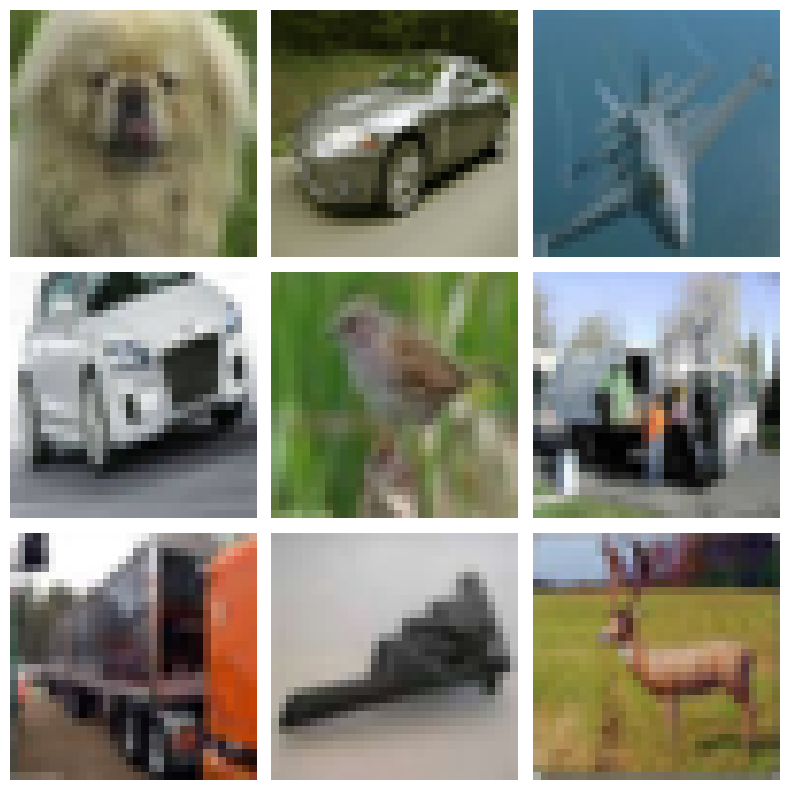

In [ ]:
show_cifar10()

## ResNet 모델 학습하기

> 직접 구현한 ResNet 모델과 CIFAR-10 데이터셋을 이용하여 분류기를 학습시켜본다.
>
> 학습에 앞서 세가지의 유용한 함수를 선언해준다.\
> 학습 중간에 loss의 값이 어떻게 변하는지를 시각화 해주는 loss_plot함수를 구현한다.

In [ ]:
def acc_plot(acc):
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0

> 학습이 시작한 후 시간이 얼마나 흘렀는지를 확인할 수 있는 Timer 클래스를 구현한다.

In [ ]:
import datetime
import time
class Timer():
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]

> 테스트 데이터로 모델의 일반화 성능을 측정하기 위한 함수를 구현한다.

In [ ]:
def test_on_cifar10(model, accuracy_list):
    model.eval()    # eval 모드로 변경 (Batch Normalization이 moving mean/var를 사용하도록, dropout을 적용하지 않도록 설정)
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct / total))
    accuracy_list.append(100 * correct / total)
    return accuracy_list

> 하이퍼파라미터를 설정한다.

In [ ]:
batch_size = 64
learning_rate = 0.0001
num_epochs = 1

> 모델, 목적 함수, 최적화 모듈을 설정한 후 지정한 에폭 수 만큼 모델을 학습한다. \
> 이때 모델과 데이터 둘 다 cuda함수를 통해 GPU에서의 연산을 가능하게 한다.

[+] Get the CIFAR10 DATA
Files already downloaded and verified
[+] Finished loading data & Preprocessing
Epoch [1/1], Iter [100/781] Loss: 1.5549, iter_time: 11.32
Test Accuracy of the model on the 100 test images: 41 %
Epoch [1/1], Iter [200/781] Loss: 1.6217, iter_time: 15.02
Test Accuracy of the model on the 100 test images: 42 %
Epoch [1/1], Iter [300/781] Loss: 1.5094, iter_time: 13.39
Test Accuracy of the model on the 100 test images: 45 %
Epoch [1/1], Iter [400/781] Loss: 1.2691, iter_time: 13.47
Test Accuracy of the model on the 100 test images: 42 %
Epoch [1/1], Iter [500/781] Loss: 1.3828, iter_time: 13.55
Test Accuracy of the model on the 100 test images: 50 %
Epoch [1/1], Iter [600/781] Loss: 1.3075, iter_time: 13.77
Test Accuracy of the model on the 100 test images: 47 %
Epoch [1/1], Iter [700/781] Loss: 1.3353, iter_time: 14.99
Test Accuracy of the model on the 100 test images: 52 %


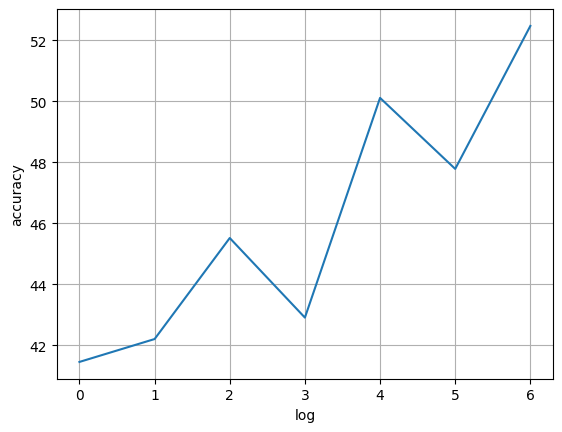

In [ ]:
tell_time = Timer()
iter_time = 0

train_dataset, test_dataset, train_loader, test_loader = CIFAR10_DATA(batch_size = batch_size)

resnet = resnet.cuda() # 생성한 뉴럴넷 Instance를 생성
criterion = nn.CrossEntropyLoss() # cross entrophy loss 함수 정의
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate) # 학습할 모델의 parameter와 learning rate를 인자로 주어 optimizer 정의

accuracy_list = []
for epoch in range(num_epochs):
    resnet.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = resnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(resnet, accuracy_list)

    acc_plot(accuracy_list)

## Pre-trained ResNet fine-tuning 하기

> 사전 학습된 ResNet을 불러와서 테스트를 해본다. \
> 양질의 데이터를 통해 학습되어 있는 모델의 정보를 직접 학습하지 않고 사용할 수 있게 되어서, 효율적으로 classification 성능 향상을 할 수 있다. \
> torchvision 라이브러리에 내장되어 있는 사전 학습된 ResNet을 이용한다. \
> 이 ResNet은 1,000개의 클래스를 가지는 ImageNet 데이터셋으로 학습되어 있기 때문에, 마지막 MLP레이어를 CIFAR10에 맞게 새로 정의한 후 fine-tuning 한다.

> torchvision library를 이용하여 사전 학습된 ResNet을 정의한다.

In [ ]:
import torchvision.models as models
resnet=models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


> 사전 학습된 모델이 1,000개의 클래스 중 하나를 예측하는 모델이므로, 마지막 MLP레이어를 10개의 클래스를 예측하도록 새로 정의한다.

In [ ]:
# 학습할 데이터의 class 개수 설정
num_classes=10

# fine tuning할 MLP 레이어를 새롭게 정의
resnet.fc=nn.Linear(resnet.fc.in_features,num_classes,bias=True)

> 모델, 목적함수, 최적화 모듈을 정의한다.

In [ ]:
res50 = resnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res50.parameters(), lr=learning_rate)

> 정해놓은 에폭 수만큼 fine-tuning한다.

<ipython-input-51-5bc5557cf3ef>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).cuda()
<ipython-input-51-5bc5557cf3ef>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).cuda()


Epoch [1/1], Iter [100/781] Loss: 1.1344, iter_time: 5.19
Test Accuracy of the model on the 100 test images: 61 %
Epoch [1/1], Iter [200/781] Loss: 0.9017, iter_time: 6.88
Test Accuracy of the model on the 100 test images: 68 %
Epoch [1/1], Iter [300/781] Loss: 0.6451, iter_time: 6.77
Test Accuracy of the model on the 100 test images: 71 %
Epoch [1/1], Iter [400/781] Loss: 0.6529, iter_time: 6.82
Test Accuracy of the model on the 100 test images: 75 %
Epoch [1/1], Iter [500/781] Loss: 0.8238, iter_time: 7.41
Test Accuracy of the model on the 100 test images: 77 %
Epoch [1/1], Iter [600/781] Loss: 0.5265, iter_time: 7.15
Test Accuracy of the model on the 100 test images: 76 %
Epoch [1/1], Iter [700/781] Loss: 0.7970, iter_time: 6.78
Test Accuracy of the model on the 100 test images: 77 %


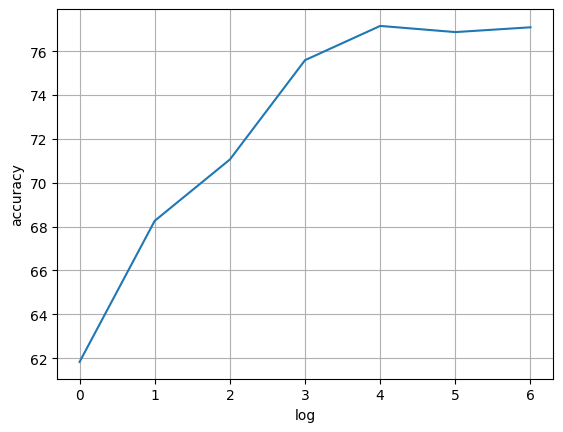

In [ ]:
tell_time = Timer()
iter_time = 0

accuracy_list = []
for epoch in range(num_epochs):
    res50.train()
    for i, (images, labels) in enumerate(train_loader):
        images = torch.tensor(images).cuda()
        labels = torch.tensor(labels).cuda()

        optimizer.zero_grad()
        outputs = res50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(res50, accuracy_list)

    acc_plot(accuracy_list)